Initializing the spark session and loading the data

In [1]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
from pyspark.sql.functions import *
spark = SparkSession.builder\
    .appName('NYC Taxi traffic analysis')\
    .getOrCreate()

24/05/25 18:03:11 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [2]:
df = spark.read.format("parquet").load("gs://pyspark-tutorial-sanjayadg98rc/data/NYC/*.parquet")

In [3]:
df.limit(5).toPandas()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2021-06-01 00:13:26,2021-06-01 00:17:14,1.0,0.90,1.0,N,186,50,1,5.0,3.00,0.5,2.20,0.00,0.3,11.00,2.5,0.00
1,1,2021-06-01 00:32:23,2021-06-01 01:07:04,1.0,23.00,1.0,N,132,18,2,61.5,1.75,0.5,0.00,6.55,0.3,70.60,0.0,1.25
2,1,2021-06-01 00:12:15,2021-06-01 00:15:28,0.0,0.90,1.0,N,138,70,2,5.0,1.75,0.5,0.00,0.00,0.3,7.55,0.0,1.25
3,1,2021-06-01 00:35:00,2021-06-01 00:53:17,0.0,11.20,1.0,N,138,189,1,31.5,1.75,0.5,8.50,0.00,0.3,42.55,0.0,1.25
4,2,2021-06-01 00:31:01,2021-06-01 00:52:27,1.0,9.49,1.0,N,138,142,1,28.5,0.50,0.5,7.77,6.55,0.3,47.87,2.5,1.25


In [7]:
df_trip = df.withColumn("trip_duration_mins", (unix_timestamp("tpep_dropoff_datetime") - unix_timestamp("tpep_pickup_datetime"))/60)

df_trip_hour = df_trip.groupBy(hour("tpep_pickup_datetime").alias("hour")).agg(avg("trip_duration_mins").alias("avg_duration"),avg("trip_distance").alias("avg_distance")).orderBy("hour")

Trip Analysis

In [9]:
# List of valid files, excluding the corrupted one
valid_files = [
    "gs://pyspark-tutorial-sanjayadg98rc/data/NYC/yellow_tripdata_2021-02.parquet",
    "gs://pyspark-tutorial-sanjayadg98rc/data/NYC/yellow_tripdata_2021-04.parquet",
    "gs://pyspark-tutorial-sanjayadg98rc/data/NYC/yellow_tripdata_2021-05.parquet",
    "gs://pyspark-tutorial-sanjayadg98rc/data/NYC/yellow_tripdata_2021-06.parquet",
    "gs://pyspark-tutorial-sanjayadg98rc/data/NYC/yellow_tripdata_2021-07.parquet"
]

# Read only the valid files
df = spark.read.format("parquet").load(valid_files)

# Proceed with the trip duration calculation and analysis
from pyspark.sql.functions import avg, col, hour, unix_timestamp

# Calculate the trip duration in minutes
df_trip = df.withColumn("trip_duration_mins", 
                        (unix_timestamp("tpep_dropoff_datetime") - unix_timestamp("tpep_pickup_datetime")) / 60)

# Extract the hour from the pickup datetime
df_trip = df_trip.withColumn("hour", hour("tpep_pickup_datetime"))

# Calculate average duration and distance of rides by hour of the day
avg_duration_distance_hour = df_trip.groupBy("hour").agg(
    avg("trip_distance").alias("avg_trip_distance"),
    avg("trip_duration_mins").alias("avg_trip_duration")
)

# Show the results
avg_duration_distance_hour.show()


+----+------------------+------------------+
|hour| avg_trip_distance| avg_trip_duration|
+----+------------------+------------------+
|  12| 5.820839924695875|16.175897093322405|
|   1| 6.640357568365864|15.098756054058196|
|   6| 28.02439043863655|15.440061428664496|
|   3|  6.81339106298135| 15.71949581036526|
|   4| 72.52839293128471| 17.46730200332142|
|   8|11.904500984747887|15.284661459092376|
|  11| 8.673465285290003|15.517056262114941|
|  19| 4.375370219467615|14.513383615978704|
|  23| 5.490993956214427|15.495781768190481|
|  21|6.3102071118112795|14.634844374434806|
|  14|  5.54930342207724| 17.41940956048447|
|  16| 6.113193911052908|18.440438297263317|
|  20|3.9720322127016714| 14.25264639688818|
|   5| 35.69769673523285|16.464578746513922|
|  15| 6.036260148705351|18.268175947403332|
|   2| 6.787166808785247|15.086418650564978|
|  18|3.6466521832819487|15.674157304472931|
|  13| 6.962711057515882|16.517104480155023|
|  17| 4.563265991814639|  17.2649595799215|
|   7|15.5

In [12]:
from pyspark.sql.functions import dayofweek, month

# Extract day of the week and month from the pickup datetime
df_trip = df_trip.withColumn("dayofweek", dayofweek("tpep_pickup_datetime"))
df_trip = df_trip.withColumn("month", month("tpep_pickup_datetime"))

# Calculate average duration and distance by day of the week
avg_duration_distance_day = df_trip.groupBy("dayofweek").agg(
    avg("trip_distance").alias("avg_trip_distance"),
    avg("trip_duration_mins").alias("avg_trip_duration")
)

# Calculate average duration and distance by month of the year
avg_duration_distance_month = df_trip.groupBy("month").agg(
    avg("trip_distance").alias("avg_trip_distance"),
    avg("trip_duration_mins").alias("avg_trip_duration")
)

# Show the results
avg_duration_distance_day.show()
avg_duration_distance_month.show()


+---------+-----------------+------------------+
|dayofweek|avg_trip_distance| avg_trip_duration|
+---------+-----------------+------------------+
|        1|6.873271460642848|15.352597054170268|
|        6|7.291971196377952|16.822480435708947|
|        3|7.515060647664178|15.897498255409005|
|        4|6.815583878868063|16.291520576689344|
|        5|7.370227820364054|16.965636629013503|
|        2| 7.49890311900299| 15.41862265477753|
|        7|7.203423349995691|15.568436554128317|
+---------+-----------------+------------------+



+-----+------------------+------------------+
|month| avg_trip_distance| avg_trip_duration|
+-----+------------------+------------------+
|   12|2.4214285714285713|247.56071428571425|
|    1| 2.771467889908257| 323.3694189602447|
|    6| 6.933834833342703| 16.82647779882308|
|    4| 7.385729455676166|15.510029424481331|
|    8| 4.357222222222222| 39.11388888888889|
|    7|7.7863143127397105| 16.62290803773677|
|    5| 8.422948626463782|15.906414216495014|
|   11|2.0100000000000002| 83.39000000000001|
|    9|1.3299999999999998|149.08888888888887|
|   10|2.8800000000000003|153.83888888888887|
|    3| 3.893636363636364| 9.766666666666666|
|    2| 4.282101783362969|14.885600131129946|
+-----+------------------+------------------+



In [13]:
from pyspark.sql.functions import desc

# Top 10 pickup locations
top_pickup_locations = df_trip.groupBy("PULocationID").count().orderBy(desc("count")).limit(10)
top_pickup_locations.show()

# Top 10 dropoff locations
top_dropoff_locations = df_trip.groupBy("DOLocationID").count().orderBy(desc("count")).limit(10)
top_dropoff_locations.show()


+------------+------+
|PULocationID| count|
+------------+------+
|         237|604042|
|         236|562137|
|         186|392034|
|         161|391164|
|         142|372873|
|         170|372301|
|         239|365116|
|         141|360151|
|         162|351023|
|         132|347755|
+------------+------+



+------------+------+
|DOLocationID| count|
+------------+------+
|         236|559873|
|         237|525747|
|         161|358854|
|         141|352910|
|         170|351466|
|         239|344379|
|         142|319986|
|         238|306595|
|         162|283211|
|          48|280091|
+------------+------+



Tip analysis

In [14]:
# Calculate tip percentage
df_trip = df_trip.withColumn("tip_percentage", (col("tip_amount") / col("total_amount")) * 100)

# Average tip percentage by pickup location
avg_tip_by_pickup = df_trip.groupBy("PULocationID").agg(avg("tip_percentage").alias("avg_tip_percentage"))
avg_tip_by_pickup.show()

# Average tip percentage by dropoff location
avg_tip_by_dropoff = df_trip.groupBy("DOLocationID").agg(avg("tip_percentage").alias("avg_tip_percentage"))
avg_tip_by_dropoff.show()


+------------+------------------+
|PULocationID|avg_tip_percentage|
+------------+------------------+
|          65| 9.515493201343062|
|         243| 5.918221513586724|
|          77|1.2104431440961068|
|         188|1.8146636061189827|
|         149|0.8942232437234415|
|          94|1.3711325141132122|
|          25| 8.145635833815497|
|         181| 7.877879777575784|
|         124|1.2836855772969311|
|          58| 2.283872100202245|
|          56|2.2816565538245333|
|         150|1.0427532985885895|
|          79|12.241839687174217|
|         236|12.266827167087394|
|         226| 7.263364346822973|
|          41| 7.999877018641662|
|          33|10.438574836019571|
|          96| 2.018163002680829|
|         197|1.5445016275096366|
|         106| 5.344837621083298|
+------------+------------------+
only showing top 20 rows



+------------+------------------+
|DOLocationID|avg_tip_percentage|
+------------+------------------+
|          65|10.734195433534314|
|         243| 9.577812885822059|
|          77| 1.876635689973446|
|         188| 6.079689294053521|
|         149| 4.206724580806132|
|          94|2.4096658091925134|
|          25|11.130932145386199|
|         124| 4.443385085004084|
|         181|11.890554437199533|
|          58| 5.589125687944345|
|          56|  3.48905736256424|
|         150| 4.133321131457634|
|          79| 12.40076841148998|
|         236|12.442404165027456|
|         226|  8.26746445681378|
|          41| 9.086611952531788|
|          33|12.626589871797055|
|          96|3.4886603037402453|
|         197|2.9925450945494645|
|         106|10.903435813087901|
+------------+------------------+
only showing top 20 rows




[Stage 25:>                                                         (0 + 1) / 1]



In [15]:
# Average tip percentage by hour of the day
avg_tip_hour = df_trip.groupBy("hour").agg(avg("tip_percentage").alias("avg_tip_percentage"))
avg_tip_hour.show()

# Average tip percentage by day of the week
avg_tip_day = df_trip.groupBy("dayofweek").agg(avg("tip_percentage").alias("avg_tip_percentage"))
avg_tip_day.show()

# Average tip percentage by month of the year
avg_tip_month = df_trip.groupBy("month").agg(avg("tip_percentage").alias("avg_tip_percentage"))
avg_tip_month.show()


+----+------------------+
|hour|avg_tip_percentage|
+----+------------------+
|  12|11.038804534809943|
|   1| 11.30472405497016|
|   6| 10.28140571802819|
|   3|10.562495453870566|
|   4| 9.233002880914455|
|   8|11.658806122475363|
|  11| 10.98634978196156|
|  19|11.882471344385142|
|  23|11.606998057587562|
|  21|12.032714582957958|
|  14|11.047147861697214|
|  16|11.176170626258214|
|  20|11.849689419812126|
|   5| 8.829845624856056|
|  15|11.107879824975832|
|   2| 11.10951944081305|
|  18| 11.88820139562224|
|  13|11.026711458900095|
|  17| 11.58068760266477|
|   7|11.234853806077242|
+----+------------------+
only showing top 20 rows



+---------+------------------+
|dayofweek|avg_tip_percentage|
+---------+------------------+
|        1| 11.41432825023056|
|        6| 11.32441480216295|
|        3| 11.30948595029274|
|        4|  11.4031769097591|
|        5|11.423226945149972|
|        2|11.131864096408535|
|        7|11.502108074579816|
+---------+------------------+



+-----+------------------+
|month|avg_tip_percentage|
+-----+------------------+
|   12| 4.231546952511679|
|    1| 4.508531526270054|
|    6| 11.57738076524702|
|    8| 9.924558856492094|
|   11| 8.637110016420362|
|    5|11.455040278011476|
|    7| 11.41079967731758|
|    9| 4.065040650406504|
|   10| 8.887352507374631|
|    4|11.188833987684074|
|    3|10.104373945837361|
|    2|10.920506585996952|
+-----+------------------+



In [16]:
# Average tip percentage by payment type
avg_tip_payment_type = df_trip.groupBy("payment_type").agg(avg("tip_percentage").alias("avg_tip_percentage"))
avg_tip_payment_type.show()


+------------+--------------------+
|payment_type|  avg_tip_percentage|
+------------+--------------------+
|           1|   15.27665127059919|
|           3| 0.13546210043672335|
|           2|-0.00119590231587...|
|           0|  6.7762584163526425|
|           4| -0.3029249534411231|
|           5|                 0.0|
+------------+--------------------+



In [17]:
# Average fare by pickup location
avg_fare_by_pickup = df_trip.groupBy("PULocationID").agg(avg("fare_amount").alias("avg_fare_amount"))
avg_fare_by_pickup.show()

# Average fare by dropoff location
avg_fare_by_dropoff = df_trip.groupBy("DOLocationID").agg(avg("fare_amount").alias("avg_fare_amount"))
avg_fare_by_dropoff.show()


+------------+------------------+
|PULocationID|   avg_fare_amount|
+------------+------------------+
|          65| 19.57333806962346|
|         243| 22.95391485196969|
|          77| 31.27370192307695|
|         188|27.458207945900348|
|          94|26.330482673267333|
|         149| 36.56605305466239|
|          25|20.830970959225642|
|         181| 21.51482210327463|
|         124| 33.19128608923886|
|          58| 32.35209302325581|
|          56|30.677778576563604|
|         150|   33.636291913215|
|          79|11.303715639678066|
|         236| 9.819842191494141|
|         226|18.627812083692508|
|          41|12.191438494216971|
|          33| 20.10699975833739|
|          96| 30.11495412844037|
|         197|36.030157649587984|
|         106| 23.68900337837836|
+------------+------------------+
only showing top 20 rows



+------------+------------------+
|DOLocationID|   avg_fare_amount|
+------------+------------------+
|          65|24.831913094386202|
|         243|  27.3021711924913|
|          77| 33.15310407790639|
|         188| 32.70394471517368|
|         149| 40.63068900602417|
|          94|  33.5157213316893|
|          25| 26.26757334092841|
|         181|30.034736189608125|
|         124|27.853741007194266|
|          58| 38.59713917525773|
|          56| 27.39093186160053|
|         150| 41.80248670212767|
|          79|11.440318628268237|
|         236| 9.356915854131087|
|         226|19.030215121300074|
|          41|13.592569613030106|
|          33|22.517042414978985|
|          96|33.533854389721625|
|         197|31.437529359298335|
|         106| 28.40888003748832|
+------------+------------------+
only showing top 20 rows



In [18]:
# Average fare by passenger count
avg_fare_by_passenger = df_trip.groupBy("passenger_count").agg(avg("fare_amount").alias("avg_fare_amount"))
avg_fare_by_passenger.show()


+---------------+------------------+
|passenger_count|   avg_fare_amount|
+---------------+------------------+
|           NULL| 25.95733309092688|
|            1.0|12.215402847569107|
|            6.0|12.328132326481652|
|            5.0| 12.15830077325004|
|            2.0|12.980703832250402|
|            4.0|13.554846705885234|
|            8.0|50.406666666666666|
|            0.0|11.802798756514592|
|            7.0| 46.78615384615385|
|            3.0|12.854005919324875|
|            9.0|53.464705882352945|
+---------------+------------------+



In [19]:
# Correlation between fare amount and trip distance
fare_distance_corr = df_trip.stat.corr("fare_amount", "trip_distance")
print(f"Correlation between fare amount and trip distance: {fare_distance_corr}")


Correlation between fare amount and trip distance: 0.0013149031069877438


Traffic analysis

In [20]:
# Create a new feature for average speed (trip_distance / trip_duration in hours)
df_trip = df_trip.withColumn("avg_speed_mph", col("trip_distance") / (col("trip_duration_mins") / 60))

# Average speed by hour of the day
avg_speed_hour = df_trip.groupBy("hour").agg(avg("avg_speed_mph").alias("avg_speed_mph"))
avg_speed_hour.show()

# Average speed by day of the week
avg_speed_day = df_trip.groupBy("dayofweek").agg(avg("avg_speed_mph").alias("avg_speed_mph"))
avg_speed_day.show()

# Average speed by month of the year
avg_speed_month = df_trip.groupBy("month").agg(avg("avg_speed_mph").alias("avg_speed_mph"))
avg_speed_month.show()


+----+------------------+
|hour|     avg_speed_mph|
+----+------------------+
|  12|20.792239724394726|
|   1|30.049336038786127|
|   6| 74.21184136903958|
|   3|28.190998195508666|
|   4|337.54061399061527|
|   8| 38.69719014496452|
|  11|26.294240569786773|
|  19|18.791818021172034|
|  23| 20.68578994967401|
|  21|27.059129226807734|
|  14|25.033083322586428|
|  16| 26.18230339065174|
|  20|17.987381878769437|
|   5|  115.700482833868|
|  15|17.247996439622057|
|   2|23.752307780962873|
|  18| 15.12934687801169|
|  13| 25.90330361034058|
|  17|17.238763992982282|
|   7| 46.18161644358132|
+----+------------------+
only showing top 20 rows



+---------+------------------+
|dayofweek|     avg_speed_mph|
+---------+------------------+
|        1| 26.92480532169134|
|        6| 26.42547697297553|
|        3|31.185478325892284|
|        4| 23.81039182600499|
|        5|26.560645211403383|
|        2|25.319729357205265|
|        7| 35.71389784995072|
+---------+------------------+



+-----+------------------+
|month|     avg_speed_mph|
+-----+------------------+
|   12| 8.464356102119599|
|    1| 7.885744983527731|
|    6|30.259935322462827|
|    4| 31.14040393544802|
|    8| 14.56758778281077|
|    7| 26.85606161151289|
|    5| 32.77164940297144|
|    3|20.686893826919103|
|    2| 12.09401483546363|
|   11| 9.528672709139858|
|    9| 4.782666519333422|
|   10| 6.710374089609226|
+-----+------------------+



Demand prediction

In [21]:
from pyspark.sql.functions import to_date

# Create features for the model
df_features = df_trip.withColumn("pickup_date", to_date("tpep_pickup_datetime")) \
                     .withColumn("pickup_hour", hour("tpep_pickup_datetime")) \
                     .withColumn("pickup_dayofweek", dayofweek("tpep_pickup_datetime"))

# Show the new dataframe with features
df_features.show(5)


24/05/25 18:45:09 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+------------------+----+---------+-----+------------------+------------------+-----------+-----------+----------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|trip_duration_mins|hour|dayofweek|month|    tip_percentage|     avg_speed_mph|pickup_date|pickup_hour|pickup_dayofweek|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+------------------

In [22]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression

# Aggregate data to count pickups per hour
pickup_counts = df_features.groupBy("pickup_date", "pickup_hour", "pickup_dayofweek") \
                           .count().withColumnRenamed("count", "pickup_count")

# Prepare feature vector
assembler = VectorAssembler(inputCols=["pickup_hour", "pickup_dayofweek"], outputCol="features")
pickup_data = assembler.transform(pickup_counts)

# Train-test split
train_data, test_data = pickup_data.randomSplit([0.8, 0.2], seed=42)

# Train a linear regression model
lr = LinearRegression(labelCol="pickup_count", featuresCol="features")
lr_model = lr.fit(train_data)

# Predict on test data
predictions = lr_model.transform(test_data)
predictions.select("pickup_count", "prediction").show(5)


24/05/25 18:47:35 WARN Instrumentation: [2f130bd1] regParam is zero, which might cause numerical instability and overfitting.


+------------+------------------+
|pickup_count|        prediction|
+------------+------------------+
|           1|1444.3890526308655|
|          10|1467.6007928683598|
|           2|1823.9702344834438|
|           2|3427.6327217513217|
|           1| 5031.295209019199|
+------------+------------------+
only showing top 5 rows



Visualisations for analysis 

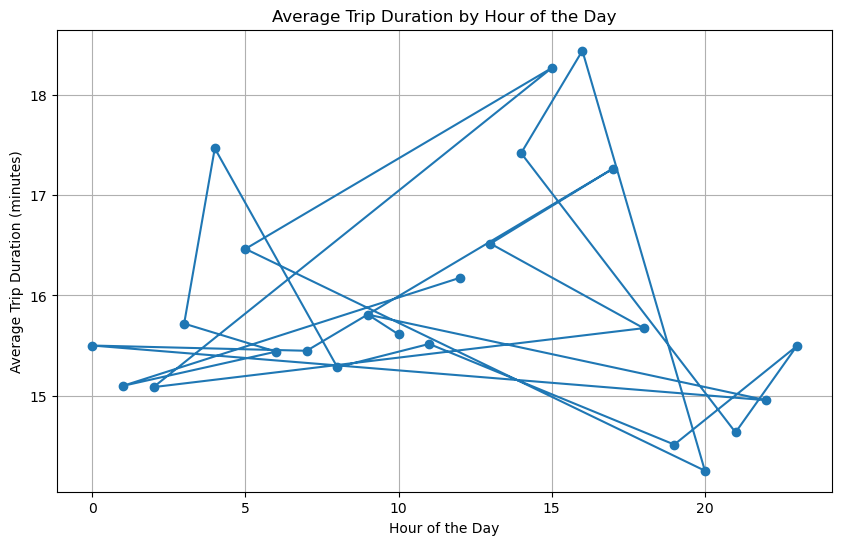

In [23]:
# Convert PySpark DataFrame to Pandas DataFrame for plotting
avg_duration_distance_hour_pd = avg_duration_distance_hour.toPandas()

# Plot average trip duration by hour
plt.figure(figsize=(10, 6))
plt.plot(avg_duration_distance_hour_pd['hour'], avg_duration_distance_hour_pd['avg_trip_duration'], marker='o')
plt.title('Average Trip Duration by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Trip Duration (minutes)')
plt.grid(True)
plt.show()